In [ ]:
import numpy as np

In [1]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

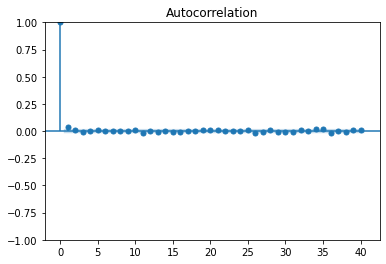

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(eps)
plt.show()

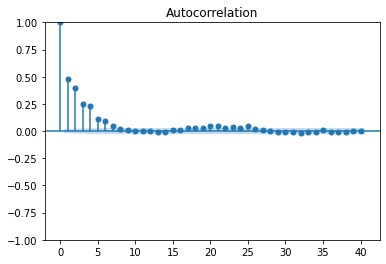

In [5]:
# Si noti che la serie sembra la realizzazione di un processo di rumore bianco discreto
# Tuttavia, se tracciamo il correlogramma del quadrato della serie vediamo che si tratta sostanzialmente di un processo condizionalmente eteroschedastico 
# attraverso il decadimento di ritardi successivi
plot_acf(eps**2)
plt.show()

In [6]:
#proviamo ad adattare un modello GARCH a questa serie simulata in modo da verificare se otteniamo gli stessi parametri della seria simulata.
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

from arch import arch_model

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.790134449831
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781716888
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318712
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Wed, Jul 13 2022   Df Residuals:                     9999
Time:       

In [7]:
#Possiamo vedere che i parametri veri rientrano tutti nei rispettivi intervalli di confidenza.

SIMULAZIONE CON DATI FINANZIARI S&P 500

In [9]:
import yfinance as yf

symbol = '^GSPC'
data = yf.download(symbol, start="2007-01-01")
data = data.asfreq('b').fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


In [10]:
#Possiamo quindi calcolare le differenze dei rendimenti logaritmici del prezzo di chiusura:

Return = data['Adj Close'].pct_change()
LogRet = np.log(data['Adj Close']).diff().dropna()

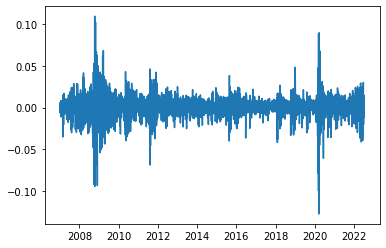

In [12]:
plt.plot(LogRet)
plt.show()

In [19]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

order_aic = []
# Loop over p values from 0-4
for p in range(5):
    # Loop over d values from 0-1
    for d in range(2):
        # Loop over q values from 0-4
        for q in range(5):
            try:
                # create and fit ARMA(p,q) model
                model = ARIMA(LogRet, order=(p, d, q))
                results = model.fit()

                # Append order and results tuple
                order_aic.append((p, d, q, results.aic, results))
            except Exception as e:
                print(str(e))
                pass

# Construct DataFrame from order_aic
order_df = pd.DataFrame(order_aic, columns=['p', 'd', 'q', 'AIC', 'Results'])

# Get the result of best order model
best_result = order_df.sort_values('AIC').iloc[0]
print("p = ", best_result.p)
print("d = ", best_result.d)
print("q = ", best_result.q)

c:\Users\Utente\Desktop\Progetto\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\Desktop\Progetto\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\Desktop\Progetto\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Utente\Desktop\Progetto\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\Desktop\Progetto\venv\l

p =  1
d =  0
q =  0


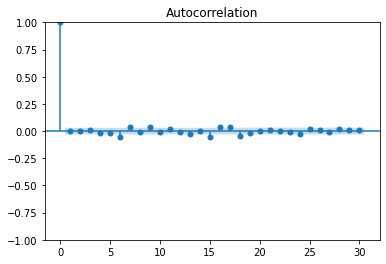

In [20]:
#Dal momento che abbiamo già differenziato i rendimenti della serie SP500, otteniamo la componente integrata d uguale a zero
'''Otteniamo un modello ARIMA(4,0,3), ovvero quattro parametri autoregressivi e tre parametri di media mobile.

Ora possiamo verificare se i residui di questo modello adattato hanno evidenze di  un comportamento  di eteroschedasticità condizionata. 
A tale scopo dobbiamo tracciare il correlogramma dei residui:'''
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Get residuals of the model
resid = best_result.Results.resid

# Plot ACF of residuals
plot_acf(resid, alpha=0.05, lags=30)
plt.show()


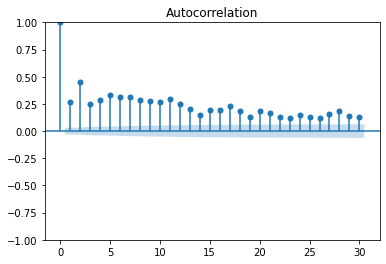

In [21]:
#Sembra la realizzazione di un processo di rumore bianco discreto che indica che abbiamo raggiunto un buon adattamento con il modello ARIMA(4,0,3).

#Per verificare il comportamento di eteroschedasticità condizionata dobbiamo quadrare i residui e tracciare il corrispondente correlogramma:

plot_acf(resid**2, alpha=0.05, lags=30)
plt.show()

In [22]:
#Possiamo vedere una chiara evidenza di correlazione seriale nei residui quadratici, 
# portandoci alla conclusione che la serie dei rendimenti logaritmici differenziati dell’S&P 500 presenta un comportamento  di eteroschedasticità condizionata

#A  questo punto siamo in grado di adattare un modello GARCH

from arch import arch_model

am = arch_model(LogRet, vol='garch')
res = am.fit(update_freq=5)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -13130.950538562196
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


c:\Users\Utente\Desktop\Progetto\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001623. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


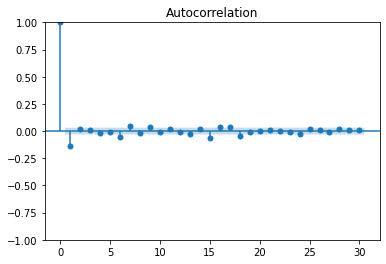

In [23]:
resid = res.resid
plot_acf(resid, alpha=0.05, lags=30)
plt.show()

In [ ]:
#l correlogramma sembra la realizzazione di un processo di rumore bianco discreto, che indica il buon adattamento del modello.
#abbiamo quella che sembra la realizzazione di un processo di rumore bianco discreto, 
# indicando che abbiamo “spiegato” la correlazione seriale presente nei residui con un’appropriata miscela di ARIMA(p,d,q) e GARCH(p, q).